In [11]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.backend import square, mean

look_back = 4 * 24
num_epochs = 8
seq_len = 4*3
batch_size=256
loss="mse"

In [12]:
def getDataset():
    url = "./datasets/DAT_ASCII_EURUSD_M1_2016.csv"
    df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
    df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df.set_axis(df['date'], inplace=True)
    df.drop(columns=["date"], inplace=True)
    df["Close"]= df["close"] # compatibility
    df.drop(columns=['close'], inplace=True)
    return df

In [13]:
# def getDataset():
#     url = "./datasets/eurusd-m15-2018/EURUSD.csv"
#     df = pd.read_csv(url)
#     df.drop("Volume", 1, inplace=True)
#     df["Date"] = df["Date"].astype(str) + " " + df["Timestamp"]
#     df['Date'] = pd.to_datetime(df['Date'])
#     df.set_index("Date", inplace=True)
#     # df.drop("Date", 1, inplace=True)
#     df.drop("Timestamp", 1, inplace=True)
#     df.drop("Open", 1, inplace=True)
#     df.drop("High", 1, inplace=True)
#     df.drop("Low", 1, inplace=True)

#     return df

df = getDataset()
df.head()

,Close
date,
2016-01-03 17:00:00,1.08713
2016-01-03 17:01:00,1.08712
2016-01-03 17:02:00,1.08722
2016-01-03 17:03:00,1.08723
2016-01-03 17:04:00,1.08711


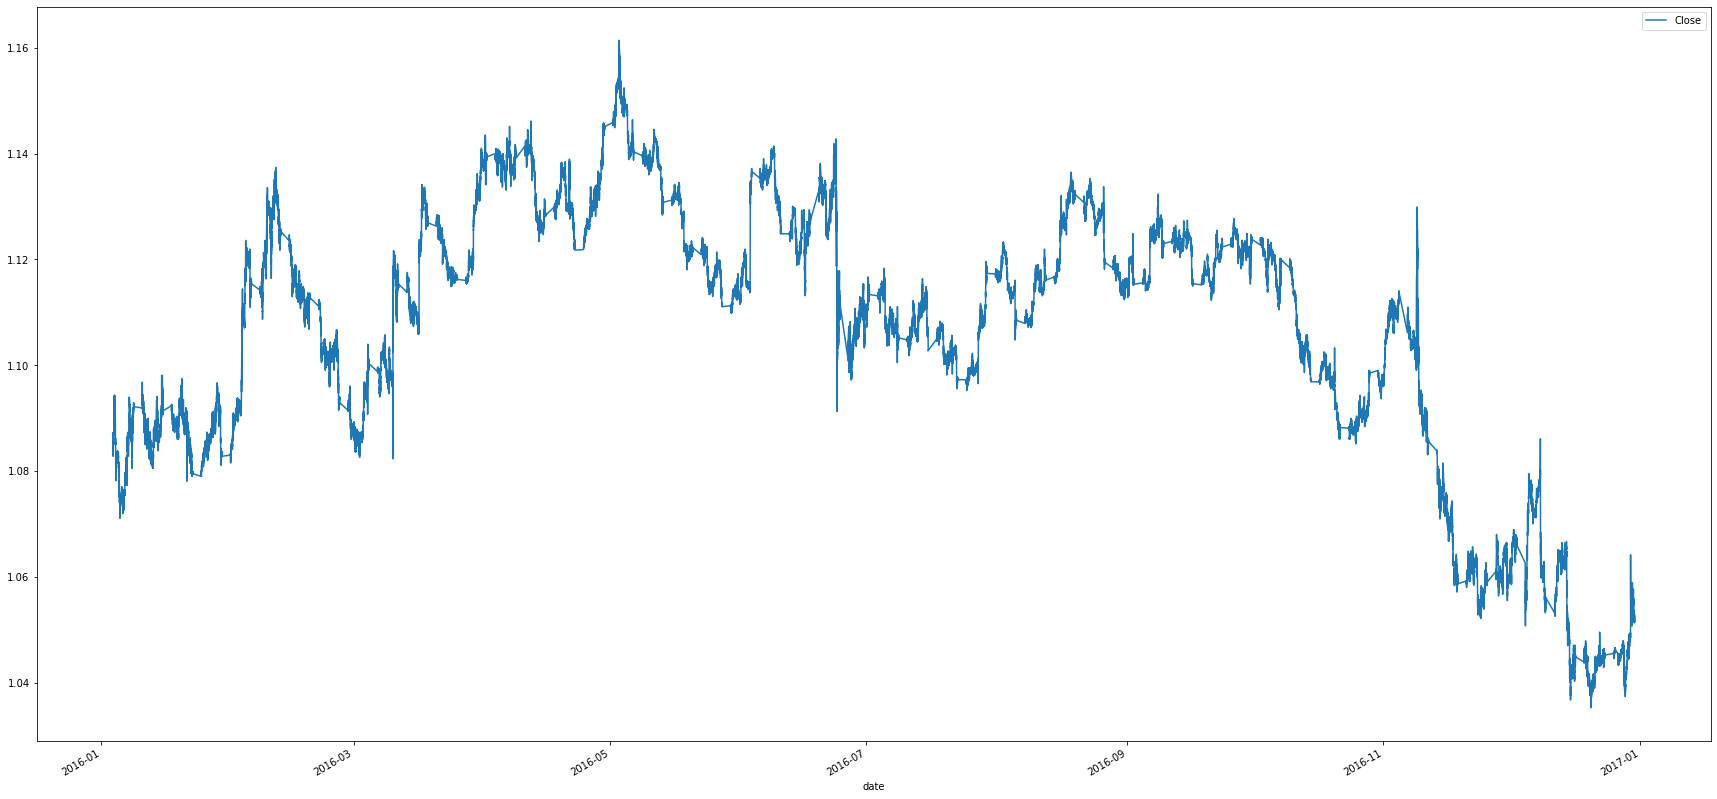

In [14]:
df.plot(figsize=(30,15))

In [15]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df.index[:split]
date_test = df.index[split:]

print(len(close_train))
print(len(close_test))

298143
74536


In [16]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

def getY(data):
    X_train = []
    y_train = []
    for i in range(look_back, len(data)-seq_len):
        X_train.append(data[i-look_back:i])
        y_train.append(data[i:i+seq_len])
    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train

x_train,y_train=getY(close_train)
x_test, y_test=getY(close_test)

print(x_train.shape)
print(y_train.shape)

(298035, 96, 1)
(298035, 12, 1)


In [17]:

x_train_reshaped = x_train.reshape(-1,1)
x_train_scaled = x_scaler.fit_transform(x_train_reshaped).reshape(-1, look_back, 1)
x_test_reshaped=x_test.reshape(-1,1)
x_test_scaled = x_scaler.transform(x_test_reshaped).reshape(-1, look_back, 1)

y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_train_scaled = y_scaler.fit_transform(y_train_reshaped).reshape(-1, seq_len, 1)
y_test_scaled = y_scaler.transform(y_test_reshaped).reshape(-1, seq_len, 1)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

validation_data = (x_test_scaled, y_test_scaled)

print(x_train_scaled.shape)               
print(y_train_scaled.shape)

Min: 0.0
Max: 1.0
(298035, 96, 1)
(298035, 12, 1)


In [18]:

warmup_steps = 8
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    # y_true_slice = y_true[:, warmup_steps:, :]
    # y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true - y_pred))
    
    return mse

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=1e-7)

model = Sequential()

# model.add(Bidirectional(GRU(units=64, return_sequences=True),input_shape=(x_train_scaled.shape[1], 1)))
model.add(GRU(units=32,input_shape=(x_train_scaled.shape[1], 1), return_sequences=True))
# model.add(BatchNormalization())
model.add(Dropout(0.15))

# model.add(GRU(units=128, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.15))

model.add(GRU(units=16))
# model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Dense(units=seq_len+10, activation="relu"))
model.add(Dropout(0.15))
model.add(Dense(units=seq_len, activation="linear"))

optimizer = RMSprop(lr=1e-3)
model.compile(optimizer=optimizer, loss=loss_mse_warmup)

In [20]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 96, 32)            3360      
_________________________________________________________________
dropout_4 (Dropout)          (None, 96, 32)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                374       
_________________________________________________________________
dropout_6 (Dropout)          (None, 22)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)               

In [21]:
history=model.fit(x_train_scaled, y_train_scaled, epochs=num_epochs, validation_data=(x_test_scaled, y_test_scaled), batch_size=batch_size, shuffle=True, verbose=1, callbacks=[reduce_lr])

Epoch 1/8


ValueError: in user code:

    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    <ipython-input-18-f30effe61c36>:16 loss_mse_warmup
        y_true_slice = y_true[:, warmup_steps:, :]
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:984 _slice_helper
        name=name)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1150 strided_slice
        shrink_axis_mask=shrink_axis_mask)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:10179 strided_slice
        shrink_axis_mask=shrink_axis_mask, name=name)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /Users/i354746/private/magisterka/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Index out of range using input dim 2; input has only 2 dims for '{{node loss_mse_warmup/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=5, ellipsis_mask=0, end_mask=7, new_axis_mask=0, shrink_axis_mask=0](loss_mse_warmup/remove_squeezable_dimensions/Squeeze, loss_mse_warmup/strided_slice/stack, loss_mse_warmup/strided_slice/stack_1, loss_mse_warmup/strided_slice/stack_2)' with input shapes: [?,12], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.


In [22]:
def plotHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['loss'], label='loss (training data)')
    ax.plot(history.history['val_loss'], label='loss (validation data)')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    ax.legend(loc="upper left")
    plt.title(f"loss = {loss}")
    plt.show()

In [23]:
plotHistory(history)

NameError: name 'history' is not defined

In [24]:
def predictAndPlot(position=0, test=False, predictionPeriods=3):
    if test:
        x = x_test_scaled
    else:
        x = x_train_scaled

    prediction_list = np.array([x[position]])
    output=[]

    for i in range(predictionPeriods):
        y = model.predict(prediction_list).reshape(1,-1)[0]
        output.append(y)

        tmp = np.append(prediction_list[0].reshape(1,-1)[0],y)[-look_back:]
        predition_list = tmp.reshape(1, look_back, 1)

    pltx=x[position].reshape(1,-1)[0]
    plty=np.array(output).reshape(1,-1)[0]

    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(pltx, label='Base', color='orange')
    ax.plot([i for i in range(len(pltx), len(plty)+len(pltx))],plty, label='Data', color = 'blue')
    ax.plot([i for i in range(len(pltx), 2*len(pltx))], x[position+len(pltx)].reshape(1,-1)[0], label='Next base', color = 'green')
    # plt.xlabel('years')
    # plt.ylabel('prices')
    # plt.savefig(f"pngs/cf{}")
    plt.show() 

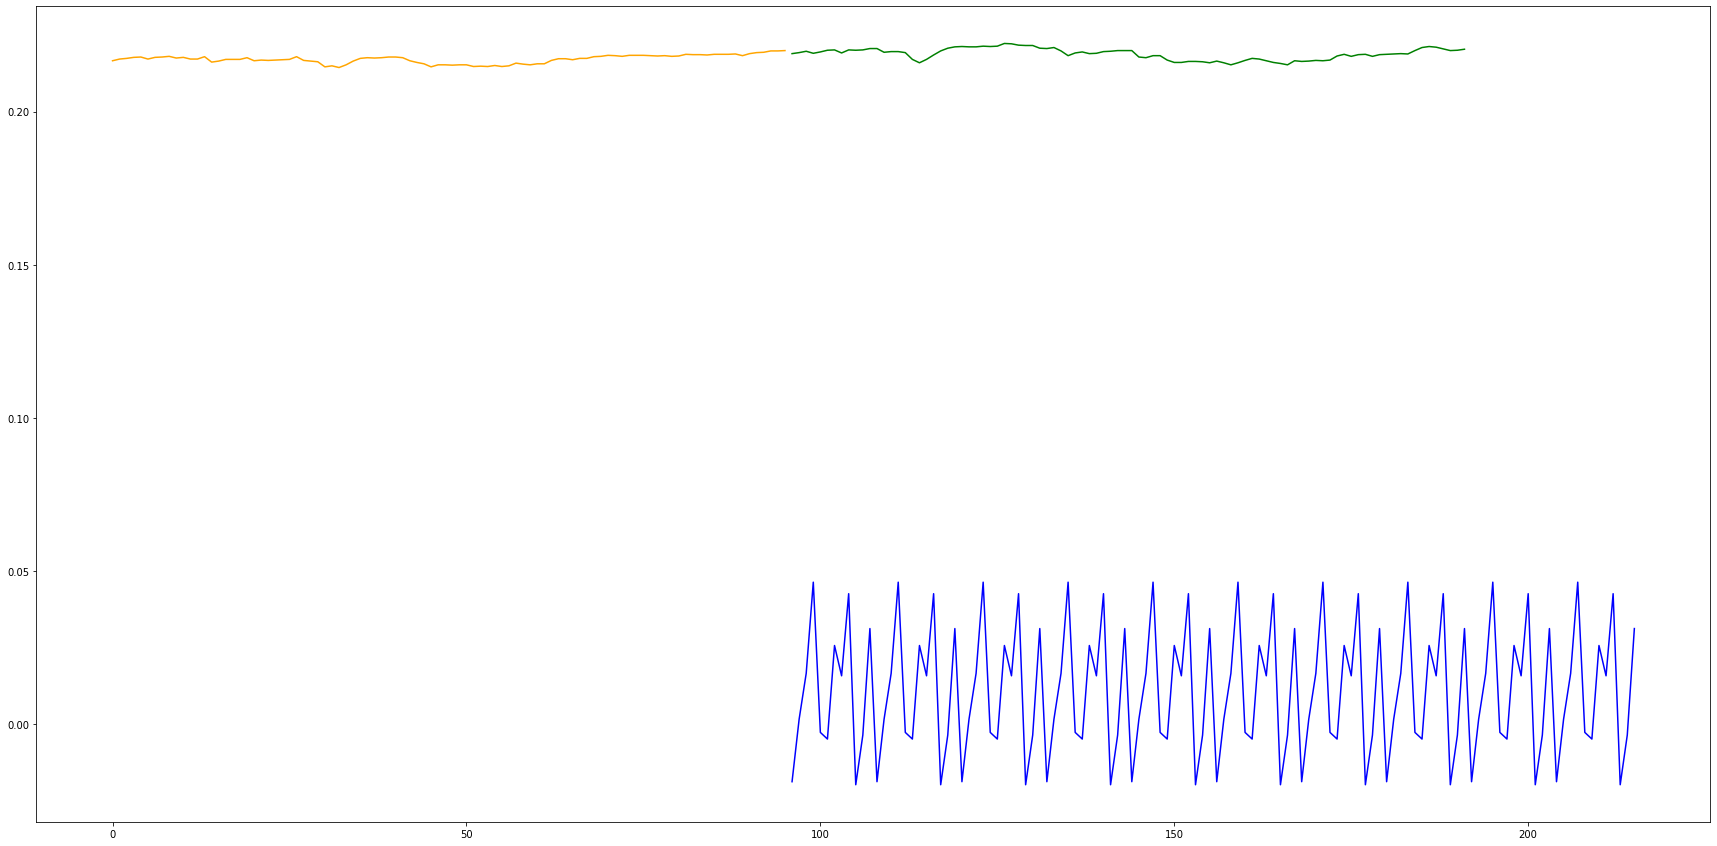

In [25]:
predictAndPlot(8000, True, 10)

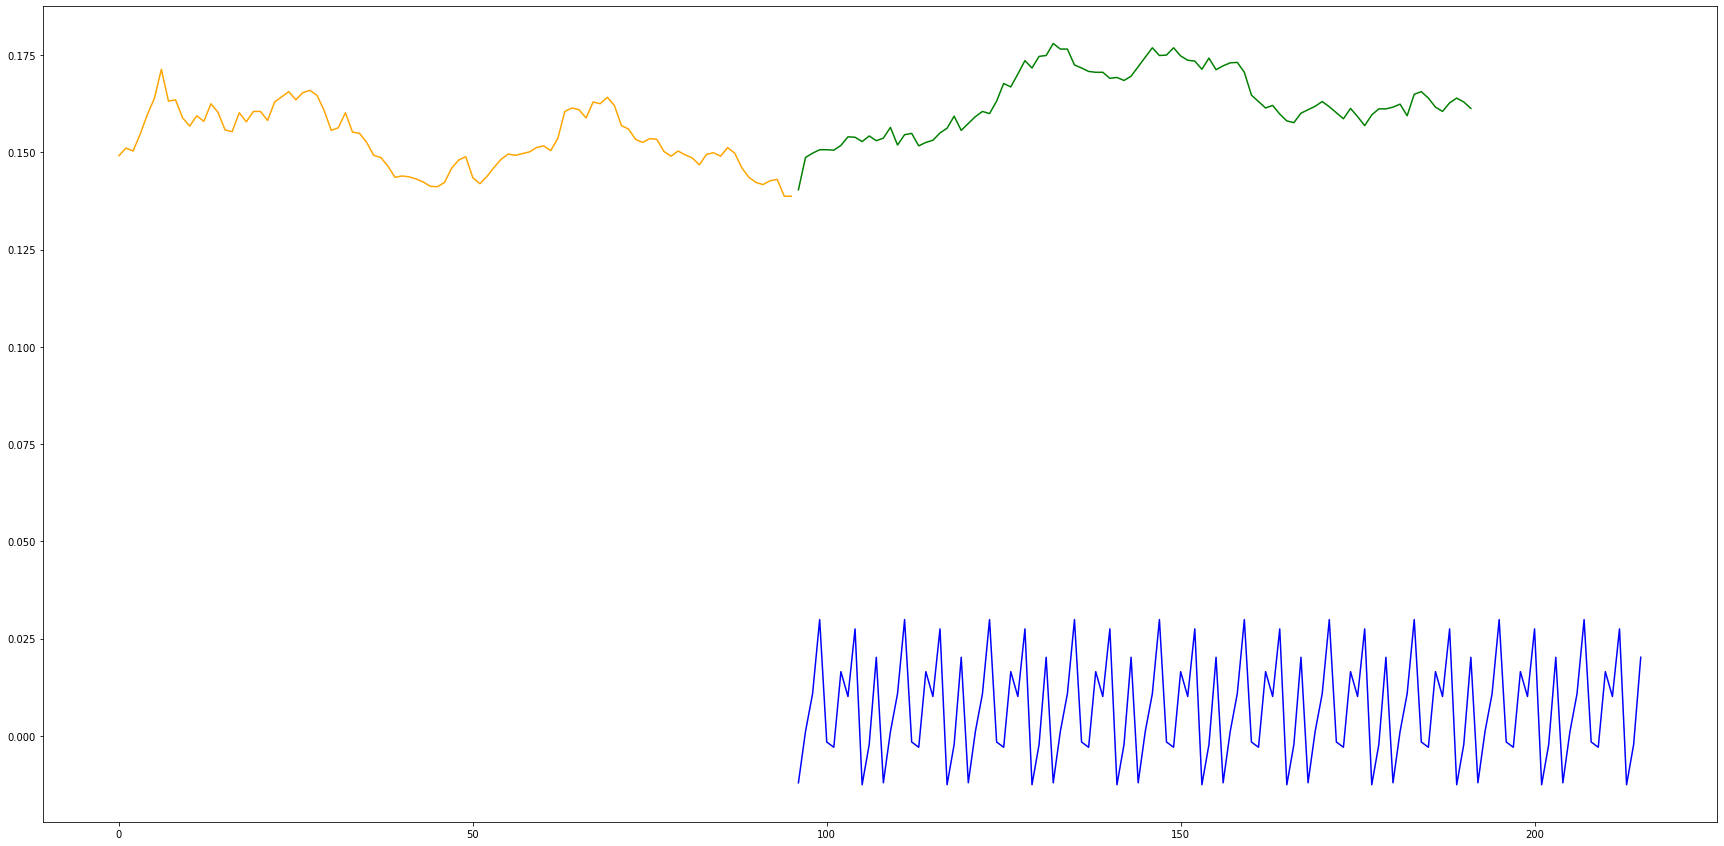

In [26]:
predictAndPlot(5000, False, 10)     

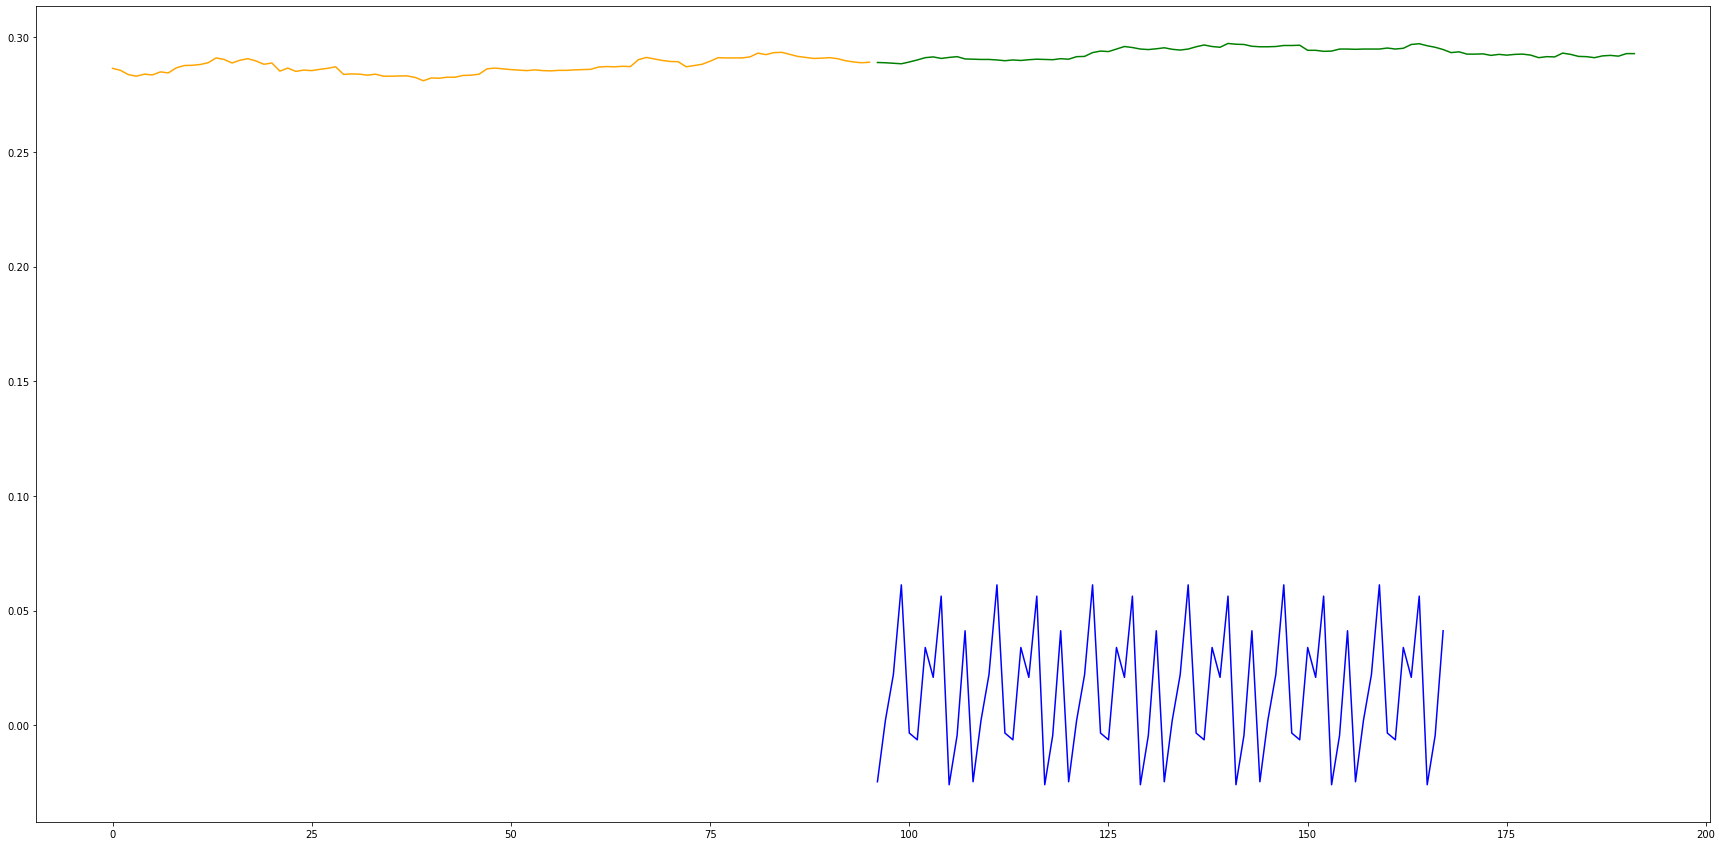

In [27]:
predictAndPlot(1000, True, 6)